## Алгоритм, основанный на признаках, полученных из HRV сигнала

In [2]:
import numpy as np
from scikits.audiolab import Sndfile
from scipy import signal
import seaborn as sns
import os
from scikits.audiolab import wavread, wavwrite
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from scipy.signal import wiener
import xgboost as xgb
from sklearn.model_selection  import GroupKFold
from biosppy.signals import ecg
from tqdm import tqdm
import math
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from itertools import chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import StandardScaler
#import gensim
from scipy.signal import butter
from scipy.signal import medfilt
from pyrqa.settings import Settings
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RecurrencePlotComputation
from pyrqa.image_generator import ImageGenerator
import nolds
import pyeeg
from scipy.stats import entropy
import numpy as np
from numpy.linalg import eig, inv
from matplotlib import pyplot as plt
from scipy.spatial.distance import chebyshev

In [3]:
from biosppy.signals.ecg import engzee_segmenter, gamboa_segmenter, hamilton_segmenter, ssf_segmenter

## СЧИТЫВАНИЕ ДАННЫХ

In [4]:
def read_frame(directory, filename):
    data, sample_frequency, encoding = wavread(directory + "/" + filename)
    return np.array(data)

def get_frames(directory, files):
    frames = []
    for i in files:
        patient = i.split("_")[0]
        ecg_id = i[:-4]
        a = read_frame(directory, i)
        frames.append([a, patient, ecg_id])
    frames = np.array(frames)
    return np.swapaxes(frames, 0, 1)

def create_data_frame_from_wav(true_files_dir, false_files_dir):
    true_files = filter(lambda x: x.endswith(".wav"), os.listdir(true_files_dir))
    false_files = filter(lambda x: x.endswith(".wav"), os.listdir(false_files_dir))
    true_frames = get_frames(true_files_dir, true_files)
    false_frames = get_frames(false_files_dir, false_files)
    a = create_data_frame(true_frames, True)
    b = create_data_frame(false_frames, False)
    df = a.append(b).copy()
    del a
    del b
    df = shuffle(df, random_state=27)
    df = df.reset_index()
    df.drop("index", axis=1, inplace=True)
    df["SignalLen"] = df["S"].apply(lambda x: len(x))
    df = df[df["SignalLen"] != 0].copy()
    return df

def create_data_frame(data, ibs):
    df = pd.DataFrame({"S":data[0], "Patient": data[1], "ibs":ibs, "ECG_ID":data[2]})
    return df

In [16]:
df_p = create_data_frame_from_wav("preprocessed/wav/true", "preprocessed/wav/false")

In [5]:
df_train = create_data_frame_from_wav("wav/true", "wav/false")
df_test = create_data_frame_from_wav("wav_test/true", "wav_test/false")

ecg_ids = pd.read_csv("test_ids.csv", header=None)
df_test = df_test[df_test["ECG_ID"].isin(ecg_ids[0])]

In [6]:
import math

## Предобработка данных

In [12]:
N  = 2   # Filter order
Wn_high = 0.3 * 2 / 2000 # Cutoff frequency
B_high, A_high = signal.butter(N, Wn_high, btype='highpass', output='ba', analog=False)
Wn_low = 15 * 2.0 / 2000 # Cutoff frequency
B_low, A_low = signal.butter(N, Wn_low, btype='lowpass', output='ba', analog=False)

In [13]:
def make_preprocessing(x):
    x_p = signal.filtfilt(B_high, A_high, x)
    x_p = signal.filtfilt(B_low, A_low, x_p)
    m = medfilt(x_p, kernel_size=55)
    x_p = x_p - m
    return x_p

In [17]:
from tqdm import tqdm

In [18]:
tqdm.pandas(desc="my bar!")

In [19]:
#df_p["PS"] = df_p["S"].progress_apply(lambda x: make_preprocessing(x))

In [34]:
def save_to_wav_file(s, ibs, patient, index):
    dir_name = "new_data/preprocessed/"
    if ibs == True:
        dir_name += "true/"
    else:
        dir_name += "false/"
    wavwrite(s, dir_name+str(patient)+"_"+str(index)+".wav", fs=1000)

In [35]:
_= new_df_unfilt[["PS", "ibs", "Patient", "index"]].apply(lambda x: save_to_wav_file(x[0], x[1],
                                                                                  x[2], x[3]), axis=1)

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

## Обнаружение R-пиков

In [7]:
def get_max(x, r):
    w = 10
    d = []
    for i in r:
        if i > 5:
            c = np.argmax(x[i-5: i+5])
            if (c+i-5) not in d:
                d.append(c+i-5)
    return d

In [43]:
df_p["RPeaks"] = df_p["S"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))

my bar!: 100%|██████████| 1798/1798 [06:49<00:00,  4.64it/s]


In [9]:
tqdm.pandas(desc="my bar!")

In [10]:
df_train["RPeaks"] = df_train["S"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))
df_test["RPeaks"] = df_test["S"].progress_apply(lambda x: get_max(x, hamilton_segmenter(x)[0]))

my bar!: 100%|██████████| 1567/1567 [05:19<00:00,  4.53it/s]


In [11]:
def pr_p(x):
    return np.array(x[1][x[0][0]:])

In [12]:
def get_hrv(r):
    rr = []
    for i in range(len(r)-1):
        rr.append(r[i+1]-r[i])
    return rr

Построение HRV сигнала

In [47]:
df_p["RR"] = df_p["RPeaks"].apply(lambda x: get_hrv(x))
df_p["HRV"] = df_p["RR"].apply(lambda x: [60.0 / i for i in x])

In [14]:
df_train["RR"] = df_train["RPeaks"].apply(lambda x: get_hrv(x))
df_train["HRV"] = df_train["RR"].apply(lambda x: [60.0 / i for i in x])

In [15]:
df_test["RR"] = df_test["RPeaks"].apply(lambda x: get_hrv(x))
df_test["HRV"] = df_test["RR"].apply(lambda x: [60.0 / i for i in x])

## Признаки основанные на Reccurence plot

In [16]:
def get_r_res(x):
    settings = Settings(x,
                        embedding_dimension=2,
                        time_delay=2,
                        neighbourhood=FixedRadius(0.003),
                        similarity_measure=EuclideanMetric,
                        theiler_corrector=1.0,
                        min_diagonal_line_length=2,
                        min_vertical_line_length=2,
                        min_white_vertical_line_length=2)
    computation = RQAComputation.create(settings, verbose=False)
    result = computation.run()
    return result

def get_rp_f(df):
    df = df.copy()
    df["res_r"] = df["HRV"].progress_apply(lambda x: get_r_res(x))
    df["REC"] = df["res_r"].progress_apply(lambda x: x.recurrence_rate)
    df["DET"] = df["res_r"].progress_apply(lambda x: x.determinism)
    df["Lmean"] = df["res_r"].progress_apply(lambda x: x.average_diagonal_line)
    df["Ed"] = df["res_r"].progress_apply(lambda x: x.entropy_diagonal_lines)
    df["Ev"] = df["res_r"].progress_apply(lambda x: x.entropy_vertical_lines)
    df["Wa"] = df["res_r"].progress_apply(lambda x: x.average_white_vertical_line)
    df.drop("res_r", inplace=True, axis=1)
    return df

## Признаки, основанные на энтропиях и DFA

In [17]:
from sklearn.metrics.pairwise import pairwise_distances

In [18]:
def get_e_vectors(x, m):
    x_is = []
    for i in range(len(x)- (m-1)):
        x_i = x[i:i+m]
        x_is.append(x_i)
    return np.array(x_is)

def d(x_i, x_j):
    return np.max(np.abs(x_i-x_j))

def c_i_m(x_is, x_i, m, r, N):
    a = np.reshape(pairwise_distances(x_is, Y = [x_i], metric = 'chebyshev'), -1)
    s = a[a < r].shape[0]
    return s * 1.0 / (N-m+1) 

def get_phi(x_is, m, r, N):
    return 1.0 / (N - m + 1) * np.sum([np.log(c_i_m(x_is, i, m, r, N)) for i in x_is])

def get_ap_entropy(x, r):
    m = 10
    N = len(x)
    x_is_m_1 = get_e_vectors(x, m-1)
    x_is_m_2 = get_e_vectors(x, m)
    return get_phi(x_is_m_1, m-1, r, N) - get_phi(x_is_m_2, m, r, N)

def get_sh_en(x):
    n = len(x)
    if n <= 1:
        return 0
    counts = np.bincount(x)
    probs = counts * 1.0 / n
    en = entropy(probs)
    return en

def get_entropies_features(df):
    df = df.copy()
    df["rd"] = df["HRV"].apply(lambda x: 0.2 * np.std(x))
    df["ap_e"] = df[["HRV", "rd"]].progress_apply(lambda x: get_ap_entropy(x[0], x[1]), axis=1)
    df["cor_d"] = df["HRV"].progress_apply(lambda x: nolds.corr_dim(x, emb_dim=10))
    df["se"] = df[["HRV", "rd"]].apply(lambda x: pyeeg.samp_entropy(np.array(x[0]), 10, x[1]), axis=1)
    df["dfa"] = df["RR"].progress_apply(lambda x: nolds.dfa(x))
    df["sh_en"] = df["HRV"].progress_apply(lambda x: get_sh_en(x))
    return df

## Признаки, основанные на Poincare Plot

In [19]:
def get_poincare_plt(x):
    p_x = []
    p_y = []
    for i in range(len(x)-1):
        p_x.append(x[i])
        p_y.append(x[i+1])
    return [p_x, p_y]

def fit_ellipse(data):
    x = np.array(map(float, data[0]))
    y = np.array(map(float, data[1]))

    D1 = np.mat(np.vstack([x**2, x*y, y**2])).T
    D2 = np.mat(np.vstack([x, y, np.ones(len(x))])).T
    
    S1 = D1.T*D1
    S2 = D1.T*D2
    S3 = D2.T*D2  
    
    C1 = np.mat('0. 0. 2.; 0. -1. 0.; 2. 0. 0.')
    M=C1.I*(S1-S2*S3.I*S2.T)
    eval, evec = np.linalg.eig(M) 
    cond = 4*np.multiply(evec[0, :], evec[2, :]) - np.power(evec[1, :], 2)
    a1 = evec[:, np.nonzero(cond.A > 0)[1]]
    a2 = -S3.I*S2.T*a1
    coef = np.vstack([a1, a2])

    return coef
        
def get_parameters(coef):
    a = coef[0,0]
    b = coef[1,0]/2.
    c = coef[2,0]
    d = coef[3,0]/2.
    f = coef[4,0]/2.
    g = coef[5,0]
    
    x0 = (c*d-b*f)/(b**2.-a*c)
    y0 = (a*f-b*d)/(b**2.-a*c)
    
    numerator = 2*(a*f*f+c*d*d+g*b*b-2*b*d*f-a*c*g)
    denominator1 = (b*b-a*c)*( (c-a)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*( (a-c)*np.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    width = np.sqrt(numerator/denominator1)
    height = np.sqrt(numerator/denominator2)

    phi = .5*np.arctan((2.*b)/(a-c))

    return [x0, y0], width, height, phi


def get_poincare_plots_f(df):
    df = df.copy()
    df["p_plot"] = df["RR"].progress_apply(lambda x: get_poincare_plt(x))
    df["params"] = df["p_plot"].progress_apply(lambda x: get_parameters(fit_ellipse(x)))
    df["SD1"] = df["params"].apply(lambda x: x[1])
    df["SD2"] = df["params"].apply(lambda x: x[2])
    return df

In [20]:
def get_features(df):
    df = df.copy()
    df = get_rp_f(df)
    print "rp_done"
    df = get_entropies_features(df)
    print "en_done"
    df = get_poincare_plots_f(df)
    print "p_done"
    df.drop("S", inplace=True, axis=1)
    return df

In [58]:
df_p["RRlen"] = df_p["RR"].apply(lambda x: len(x))
df_p = df_p[df_p["RRlen"] > 40].copy()
df_p.reset_index(inplace=True)
df_p.drop("index", axis=1, inplace=True)


In [61]:
f_df = get_features(df_p)

my bar!: 100%|██████████| 1794/1794 [00:00<00:00, 119399.89it/s]
my bar!: 4it [00:00, 25.83it/s]               

rp_done


my bar!: 1794it [01:51, 16.02it/s]
my bar!:   0%|          | 0/1794 [00:00<?, ?it/s]

en_done


my bar!: 100%|██████████| 1794/1794 [00:01<00:00, 1253.98it/s]

p_done


In [23]:
df_test["RRlen"] = df_test["RR"].apply(lambda x: len(x))
df_test = df_test[df_test["RRlen"] > 40].copy()
df_test.reset_index(inplace=True)
df_test.drop("index", axis=1, inplace=True)

In [26]:
f_df_train = pd.read_csv("novel_f_new_f.csv")

In [29]:
f_df_test = get_features(df_test)

bar:   0%|          | 0/2 [00:00<?, ?it/s]              

rp_done


bar:   0%|          | 0/1564 [00:00<?, ?it/s]/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/nolds/measures.py:50: RuntimeWarning: RANSAC did not reach consensus, using numpy's polyfit
  RuntimeWarning)
bar:   9%|▉         | 147/1564 [00:18<03:13,  7.31it/s] /Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
bar:  10%|█         | 164/1564 [00:20<03:00,  7.76it/s]/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
bar:  14%|█▍        | 220/1564 [00:27<02:59,  7.49it/s]/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
bar:  16%|█▌        | 244/1564 [00:30<02:28,  8.91it/s]/Users/GoormanMcBook/anaconda/lib/python2.7/site-packages/nump

en_done


p_done


In [24]:
tqdm.pandas(desc = "bar", leave = False)

In [63]:
f_df.to_csv("novel_f_new_f.csv")

## Функции для обучения классификатора и кроссвалидациии

In [30]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

In [31]:
def cv_tt(df, target, cv):
    tt = []
    data = df.drop(target, axis = 1)
    y = df[target]
    for itrain, itest in cv:
        train_data = data.loc[itrain,:]
        test_data = data.loc[itest,:]
        train_data.reset_index(inplace=True)
        test_data.reset_index(inplace=True)
        fold = {"xtrain" : train_data, "ytrain" : y[itrain], 
                "xtest" : test_data, "ytest" : y[itest]}
        tt.append(fold)
    return tt

In [39]:
def fit_predict(clf, xtrain, ytrain, xtest, ytest, clf_params, 
               fit_params, do_scaling, xgbfit, nnfit):
    if do_scaling:
        scaler = StandardScaler()
        xtrain = scaler.fit_transform(xtrain)
        xtest = scaler.transform(xtest)
            
    if xgbfit:
        fit_params["eval_set"] = \
            [(xtrain, ytrain), (xtest, ytest)]
        fit_params["sample_weight"] = \
            np.array(get_weight(ytrain))
    if nnfit:
        fit_params["w"] = \
            np.array(get_weight(ytrain))
            
    c = clf(**clf_params)
    c.fit(xtrain, ytrain, **fit_params)
    
    p_tr = c.predict(xtrain)
    pr_tr = c.predict_proba(xtrain)[:,1] 
    p_tst = c.predict(xtest)
    pr_tst = c.predict_proba(xtest)[:,1]
    
    return p_tst, pr_tst

In [40]:
def cv_fit_predict(clf, cv_tt, f_l, clf_params = {}, fit_params = {},
                   do_scaling = False, xgbfit = False, nnfit = False):
    cv_answer = []
    
    for fold in tqdm(cv_tt):
        p_tr, pr_tr, p_tst, pr_tst = fit_predict(clf, fold["xtrain"][f_l], fold["ytrain"], 
                                      fold["xtest"][f_l], fold["ytest"], 
                                      clf_params, fit_params, do_scaling, xgbfit, nnfit)
        tt_answer = {"p_train" : p_tr, "pr_train" : pr_tr, 
                     "p_test" : p_tst, "pr_test" : pr_tst}
        cv_answer.append(tt_answer)
    
    return cv_answer

In [34]:
def combine_results(clf_res, cv, length):
    a = np.zeros(length)
    pr = np.zeros(length)
    
    for res, i in zip(clf_res, cv):
        itrain, itest = i
        
        a[itest] = res["p_test"]
        pr[itest] = res["pr_test"]
        
    return a, pr

In [35]:
def get_prediction(clf, train, y_train, test, y_test, lr_f, clf_params, fit_params, do_scaling = True,
                   xgbfit = False, nnfit = False):
    p_tst, pr_tst = fit_predict(clf, train, y_train, 
                                             test, y_test, 
                                             clf_params, fit_params, do_scaling, xgbfit, nnfit)
    return p_tst, pr_tst

In [36]:
def patient_score(label, target_val, p=None):
    tmp = pd.DataFrame({'label':label, 'q':target_val == p})
    return tmp.groupby('label')['q'].mean().mean()

## Результаты на тестовой выборке

In [55]:
lrclf_params = {"C": 0.026, "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_f = [u'REC', u'DET', u'Ev', u'ap_e', 'rd',
        u'se', u'dfa', u'sh_en', "SD1", "SD2", 'cor_d']
p_tst_lr, pr_tst_lr = get_prediction(LogisticRegression, f_df_train[lr_f], f_df_train["ibs"], 
                        f_df_test[lr_f], f_df_test["ibs"], lrclf_params, lrfit_params, do_scaling = True)

In [59]:
lr_p_t = np.zeros(pr_tst_lr.shape)
lr_p_t[pr_tst_lr>0.425] = 1

In [60]:
roc_auc_score(f_df_test["ibs"], pr_tst_lr)

0.75060571349231153

In [61]:
print patient_score(f_df_test["Patient"], f_df_test["ibs"], lr_p_t)
print accuracy_score(f_df_test["ibs"], lr_p_t)
print f1_score(f_df_test["ibs"], lr_p_t)

0.706940083748
0.744245524297
0.657534246575


In [64]:
xgb_f = [u'REC', u'DET', u'Ev',  u'ap_e', u'se', u'dfa', u'sh_en', "SD1", "SD2"]
xgbclf_params = {"objective":"binary:logistic", "max_depth":5, "learning_rate":0.01,
                 "n_estimators": 515, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"error", "early_stopping_rounds":90000, "verbose":False}
p_tst_xgb, pr_tst_xgb = get_prediction(xgb.XGBClassifier, f_df_train[xgb_f], f_df_train["ibs"], 
                                      f_df_test[xgb_f], f_df_test["ibs"], xgbclf_params, xgbfit_params,
                                      do_scaling = False, xgbfit = True)

In [65]:
roc_auc_score(f_df_test["ibs"], pr_tst_xgb)

0.87777777777777777

In [73]:
xgb_p_t = np.zeros(pr_tst_xgb.shape)
xgb_p_t[pr_tst_xgb>0.44] = 1

In [74]:
print patient_score(f_df_test["Patient"], f_df_test["ibs"], xgb_p_t)
print accuracy_score(f_df_test["ibs"], xgb_p_t)
print f1_score(f_df_test["ibs"], xgb_p_t)

0.802959368669
0.797314578005
0.749010292953


In [75]:
r_df = pd.DataFrame(data={"ibs":f_df_test["ibs"], "ECG_ID":f_df_test["ECG_ID"], 
                          "HRV_PR_LR":pr_tst_lr, "HRV_P_LR":p_tst_lr,
                            "HRV_PR_XGB": pr_tst_xgb, "HRV_P_XGB":p_tst_xgb, "HRV_P_NEW_XGB": xgb_p_t, 
                            "HRV_P_NEW_LR": lr_p_t})

In [76]:
r_df.to_csv("hrv_test_results.csv")

## Результаты на кросс-валидации

In [69]:
def review(df, p=None, pr=None, target="ibs", plot = True, text = True):
    lsp = np.linspace(0, 1, 201)
    if pr is not None:
        s = [pd.DataFrame({'label':df["Patient"], 'q':(df[target] == (pr >= l).astype(float))}).q.mean() for l in lsp]
        patients = [pd.DataFrame({'label':df["Patient"], 
                       'q':(df[target] == (pr >= l).astype(float))}).groupby('label')['q'].mean().mean() for l in lsp]
    
    if plot: 
        plt.figure(figsize = (8, 4))    
        plt.plot(lsp, patients, lw=2)
        plt.plot(lsp, s, lw=2)
        plt.xlabel('threshold')
        plt.ylabel('quality')
    if p is not None: 
        tmp = pd.DataFrame({'label':df["Patient"], 'q':df[target] == p})
    tmax = np.argmax(patients)
    
    if text:
        print ('roc-auc = ' + str(roc_auc_score(df[target], pr)))
        if p is not None:
            print ("Оценка границы разбиения по умолчанию:")      
            print ('Качество по сигналам = ' + str(tmp.q.mean()))
            print ('Качество по людям = ' + str(tmp.groupby('label')['q'].mean().mean()))
        print ("Наилучшее разбиение происходит при границе " + str(lsp[tmax]))
        print ('Качество по сигналам = ' + str(s[tmax]))
        print ('Качество по людям = ' + str(patients[tmax]))
    
    return patients[tmax]

In [72]:
group_kfold = GroupKFold(n_splits=12)
cv = list(group_kfold.split(f_df, f_df["ibs"], f_df["Patient"]))

In [73]:
tt = cv_tt(f_df, "ibs", cv)

In [75]:
f_df["ibs"].value_counts()

False    1052
True      742
Name: ibs, dtype: int64

In [77]:
gr = f_df.groupby("Patient")

Отобранные признаки для Логистической Регрессии

In [79]:
lr_f = [u'REC', u'DET', u'Ev', u'ap_e', 'rd',
        u'se', u'dfa', u'sh_en', "SD1", "SD2", 'cor_d']

100%|██████████| 12/12 [00:00<00:00, 188.14it/s]


roc-auc = 0.631921740645
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.645484949833
Качество по людям = 0.704972939316
Наилучшее разбиение происходит при границе 0.425
Качество по сигналам = 0.628205128205
Качество по людям = 0.763215466963


0.7632154669632851

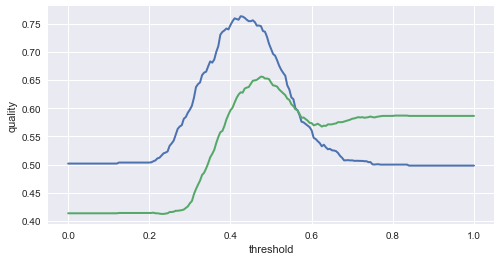

In [107]:
lrclf_params = {"C": 0.026, "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res2 = cv_fit_predict(LogisticRegression, tt, lr_f, lrclf_params, lrfit_params, do_scaling = True)
lr_p2, lr_pr2 = combine_results(lr_res2, cv, df_p.shape[0])
review(df_p, lr_p2, lr_pr2, "ibs", plot=True, text=True)

In [108]:
new_lr_p = np.zeros(len(lr_p))
new_lr_p[lr_pr2 > 0.425] = 1
print accuracy_score(new_lr_p, df_p["ibs"])

0.628205128205


100%|██████████| 12/12 [00:00<00:00, 176.44it/s]


roc-auc = 0.659566427188
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.652731326644
Качество по людям = 0.757380554636
Наилучшее разбиение происходит при границе 0.525
Качество по сигналам = 0.669453734671
Качество по людям = 0.761855862678


0.7618558626779913

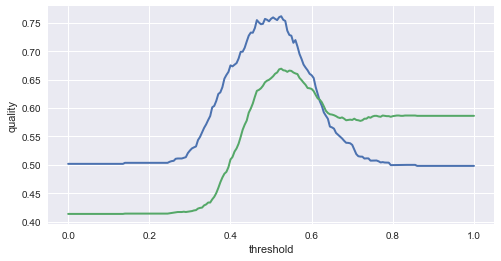

In [86]:
lrclf_params = {"C": 0.025, "class_weight" : "balanced", "n_jobs" : -1, "penalty": "l1"}
lrfit_params = {}
lr_res = cv_fit_predict(LogisticRegression, tt, lr_f, lrclf_params, lrfit_params, do_scaling = True)
lr_p, lr_pr = combine_results(lr_res, cv, df_p.shape[0])
review(df_p, lr_p, lr_pr, "ibs", plot=True, text=True)

In [91]:
def get_weight(y_train):
    false_w = 1 - len(y_train[y_train==0]) * 1.0 / len(y_train)
    true_w = 1 - len(y_train[y_train==1]) * 1.0 / len(y_train)
    d = {0: false_w, 1: true_w}
    weight = y_train.apply(lambda x: d[x])
    return weight

Отобранные признаки для xgboost

In [92]:
xgb_f = [u'REC', u'DET', u'Ev',  u'ap_e', u'se', u'dfa', u'sh_en', "SD1", "SD2"]

In [95]:
xgb_f = [u'REC', u'DET', u'Ev',  u'ap_e', u'se', u'dfa', u'sh_en', "SD1", "SD2"]
xgbclf_params = {"objective":"binary:logistic", "max_depth":5, "learning_rate":0.01,
                 "n_estimators": 515, "nthread":-1, "base_score":0.5, "seed":0, "missing":None}
xgbfit_params = {"eval_metric":"error", "early_stopping_rounds":90000, "verbose":True}
xgb_res = cv_fit_predict(xgb.XGBClassifier, tt, xgb_f, xgbclf_params, xgbfit_params, do_scaling = False, xgbfit = True)



  0%|          | 0/12 [00:00<?, ?it/s]

[0]	validation_0-error:0.229319	validation_1-error:0.38
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.227494	validation_1-error:0.38
[2]	validation_0-error:0.227494	validation_1-error:0.38
[3]	validation_0-error:0.227494	validation_1-error:0.38
[4]	validation_0-error:0.226886	validation_1-error:0.38
[5]	validation_0-error:0.226886	validation_1-error:0.38
[6]	validation_0-error:0.226886	validation_1-error:0.38
[7]	validation_0-error:0.22871	validation_1-error:0.36
[8]	validation_0-error:0.226886	validation_1-error:0.373333
[9]	validation_0-error:0.22871	validation_1-error:0.36
[10]	validation_0-error:0.23236	validation_1-error:0.36
[11]	validation_0-error:0.23236	validation_1-error:0.36
[12]	validation_0-error:0.230535	validation_1-error:0.36
[13]	validation_0-error:0.230535	validation_1-error:0.36
[14]	validation_0-error:0.230535	validation_1-er

  8%|▊         | 1/12 [00:02<00:27,  2.47s/it]

[0]	validation_0-error:0.22871	validation_1-error:0.246667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.228102	validation_1-error:0.246667
[2]	validation_0-error:0.228102	validation_1-error:0.246667
[3]	validation_0-error:0.228102	validation_1-error:0.246667
[4]	validation_0-error:0.228102	validation_1-error:0.246667
[5]	validation_0-error:0.228102	validation_1-error:0.246667
[6]	validation_0-error:0.226277	validation_1-error:0.246667
[7]	validation_0-error:0.226277	validation_1-error:0.24
[8]	validation_0-error:0.226277	validation_1-error:0.246667
[9]	validation_0-error:0.226277	validation_1-error:0.24
[10]	validation_0-error:0.226277	validation_1-error:0.24
[11]	validation_0-error:0.226277	validation_1-error:0.24
[12]	validation_0-error:0.226277	validation_1-error:0.24
[13]	validation_0-error:0.226277	validation_1-error:0.24
[14]	validation_0

 17%|█▋        | 2/12 [00:04<00:24,  2.46s/it]

[0]	validation_0-error:0.239051	validation_1-error:0.353333
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.231752	validation_1-error:0.346667
[2]	validation_0-error:0.232968	validation_1-error:0.346667
[3]	validation_0-error:0.231752	validation_1-error:0.346667
[4]	validation_0-error:0.237835	validation_1-error:0.34
[5]	validation_0-error:0.229319	validation_1-error:0.346667
[6]	validation_0-error:0.23601	validation_1-error:0.34
[7]	validation_0-error:0.23601	validation_1-error:0.34
[8]	validation_0-error:0.229927	validation_1-error:0.346667
[9]	validation_0-error:0.23601	validation_1-error:0.34
[10]	validation_0-error:0.23601	validation_1-error:0.34
[11]	validation_0-error:0.236618	validation_1-error:0.34
[12]	validation_0-error:0.23601	validation_1-error:0.34
[13]	validation_0-error:0.23601	validation_1-error:0.34
[14]	validation_0-error:0.2366

 25%|██▌       | 3/12 [00:07<00:22,  2.47s/it]

[0]	validation_0-error:0.212287	validation_1-error:0.66
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.211071	validation_1-error:0.66
[2]	validation_0-error:0.206813	validation_1-error:0.7
[3]	validation_0-error:0.206813	validation_1-error:0.7
[4]	validation_0-error:0.201946	validation_1-error:0.706667
[5]	validation_0-error:0.203163	validation_1-error:0.7
[6]	validation_0-error:0.198905	validation_1-error:0.706667
[7]	validation_0-error:0.198905	validation_1-error:0.706667
[8]	validation_0-error:0.196472	validation_1-error:0.713333
[9]	validation_0-error:0.196472	validation_1-error:0.706667
[10]	validation_0-error:0.196472	validation_1-error:0.706667
[11]	validation_0-error:0.196472	validation_1-error:0.706667
[12]	validation_0-error:0.197689	validation_1-error:0.713333
[13]	validation_0-error:0.193431	validation_1-error:0.706667
[14]	validation

 33%|███▎      | 4/12 [00:09<00:19,  2.44s/it]

[0]	validation_0-error:0.236618	validation_1-error:0.246667
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.232968	validation_1-error:0.246667
[2]	validation_0-error:0.23601	validation_1-error:0.246667
[3]	validation_0-error:0.232968	validation_1-error:0.246667
[4]	validation_0-error:0.23601	validation_1-error:0.246667
[5]	validation_0-error:0.232968	validation_1-error:0.246667
[6]	validation_0-error:0.23236	validation_1-error:0.246667
[7]	validation_0-error:0.232968	validation_1-error:0.246667
[8]	validation_0-error:0.23236	validation_1-error:0.246667
[9]	validation_0-error:0.23236	validation_1-error:0.246667
[10]	validation_0-error:0.23236	validation_1-error:0.246667
[11]	validation_0-error:0.230535	validation_1-error:0.233333
[12]	validation_0-error:0.230535	validation_1-error:0.233333
[13]	validation_0-error:0.231752	validation_1-error:0.24
[1

 42%|████▏     | 5/12 [00:12<00:16,  2.41s/it]

[0]	validation_0-error:0.24635	validation_1-error:0.18
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.24635	validation_1-error:0.18
[2]	validation_0-error:0.24635	validation_1-error:0.18
[3]	validation_0-error:0.24635	validation_1-error:0.18
[4]	validation_0-error:0.243917	validation_1-error:0.173333
[5]	validation_0-error:0.244526	validation_1-error:0.18
[6]	validation_0-error:0.234185	validation_1-error:0.18
[7]	validation_0-error:0.241484	validation_1-error:0.18
[8]	validation_0-error:0.237226	validation_1-error:0.173333
[9]	validation_0-error:0.237226	validation_1-error:0.173333
[10]	validation_0-error:0.235401	validation_1-error:0.166667
[11]	validation_0-error:0.235401	validation_1-error:0.166667
[12]	validation_0-error:0.235401	validation_1-error:0.166667
[13]	validation_0-error:0.235401	validation_1-error:0.166667
[14]	validation_0-error:

 50%|█████     | 6/12 [00:14<00:14,  2.42s/it]

[0]	validation_0-error:0.228571	validation_1-error:0.281879
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.228571	validation_1-error:0.281879
[2]	validation_0-error:0.228571	validation_1-error:0.281879
[3]	validation_0-error:0.225532	validation_1-error:0.295302
[4]	validation_0-error:0.227964	validation_1-error:0.288591
[5]	validation_0-error:0.227356	validation_1-error:0.288591
[6]	validation_0-error:0.227356	validation_1-error:0.288591
[7]	validation_0-error:0.224316	validation_1-error:0.295302
[8]	validation_0-error:0.224924	validation_1-error:0.295302
[9]	validation_0-error:0.227356	validation_1-error:0.281879
[10]	validation_0-error:0.221277	validation_1-error:0.275168
[11]	validation_0-error:0.221277	validation_1-error:0.281879
[12]	validation_0-error:0.221277	validation_1-error:0.281879
[13]	validation_0-error:0.223708	validation_1-error:0

 58%|█████▊    | 7/12 [00:16<00:11,  2.37s/it]

[0]	validation_0-error:0.220061	validation_1-error:0.281879
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.220061	validation_1-error:0.281879
[2]	validation_0-error:0.219453	validation_1-error:0.281879
[3]	validation_0-error:0.217629	validation_1-error:0.281879
[4]	validation_0-error:0.220061	validation_1-error:0.281879
[5]	validation_0-error:0.217021	validation_1-error:0.281879
[6]	validation_0-error:0.220061	validation_1-error:0.281879
[7]	validation_0-error:0.220061	validation_1-error:0.275168
[8]	validation_0-error:0.219453	validation_1-error:0.275168
[9]	validation_0-error:0.217629	validation_1-error:0.275168
[10]	validation_0-error:0.219453	validation_1-error:0.275168
[11]	validation_0-error:0.219453	validation_1-error:0.275168
[12]	validation_0-error:0.219453	validation_1-error:0.275168
[13]	validation_0-error:0.217021	validation_1-error:0

 67%|██████▋   | 8/12 [00:19<00:09,  2.41s/it]

[0]	validation_0-error:0.227356	validation_1-error:0.375839
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.22614	validation_1-error:0.375839
[2]	validation_0-error:0.22614	validation_1-error:0.375839
[3]	validation_0-error:0.22614	validation_1-error:0.375839
[4]	validation_0-error:0.22614	validation_1-error:0.375839
[5]	validation_0-error:0.221885	validation_1-error:0.375839
[6]	validation_0-error:0.222492	validation_1-error:0.362416
[7]	validation_0-error:0.220061	validation_1-error:0.369128
[8]	validation_0-error:0.222492	validation_1-error:0.362416
[9]	validation_0-error:0.221885	validation_1-error:0.355705
[10]	validation_0-error:0.219453	validation_1-error:0.369128
[11]	validation_0-error:0.219453	validation_1-error:0.369128
[12]	validation_0-error:0.221885	validation_1-error:0.355705
[13]	validation_0-error:0.218845	validation_1-error:0.369

 75%|███████▌  | 9/12 [00:21<00:07,  2.39s/it]

[0]	validation_0-error:0.220061	validation_1-error:0.369128
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.219453	validation_1-error:0.369128
[2]	validation_0-error:0.217629	validation_1-error:0.362416
[3]	validation_0-error:0.219453	validation_1-error:0.369128
[4]	validation_0-error:0.215805	validation_1-error:0.375839
[5]	validation_0-error:0.217629	validation_1-error:0.362416
[6]	validation_0-error:0.219453	validation_1-error:0.369128
[7]	validation_0-error:0.218845	validation_1-error:0.369128
[8]	validation_0-error:0.217021	validation_1-error:0.362416
[9]	validation_0-error:0.218845	validation_1-error:0.369128
[10]	validation_0-error:0.217021	validation_1-error:0.362416
[11]	validation_0-error:0.216413	validation_1-error:0.362416
[12]	validation_0-error:0.21459	validation_1-error:0.375839
[13]	validation_0-error:0.215198	validation_1-error:0.

 83%|████████▎ | 10/12 [00:24<00:04,  2.45s/it]

[0]	validation_0-error:0.240122	validation_1-error:0.268456
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.240122	validation_1-error:0.268456
[2]	validation_0-error:0.23769	validation_1-error:0.275168
[3]	validation_0-error:0.237082	validation_1-error:0.275168
[4]	validation_0-error:0.229179	validation_1-error:0.288591
[5]	validation_0-error:0.228571	validation_1-error:0.288591
[6]	validation_0-error:0.228571	validation_1-error:0.288591
[7]	validation_0-error:0.235258	validation_1-error:0.281879
[8]	validation_0-error:0.220061	validation_1-error:0.261745
[9]	validation_0-error:0.228571	validation_1-error:0.281879
[10]	validation_0-error:0.213374	validation_1-error:0.268456
[11]	validation_0-error:0.213374	validation_1-error:0.275168
[12]	validation_0-error:0.213374	validation_1-error:0.268456
[13]	validation_0-error:0.212766	validation_1-error:0.

 92%|█████████▏| 11/12 [00:26<00:02,  2.45s/it]

[0]	validation_0-error:0.234043	validation_1-error:0.33557
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 90000 rounds.
[1]	validation_0-error:0.231611	validation_1-error:0.322148
[2]	validation_0-error:0.231611	validation_1-error:0.322148
[3]	validation_0-error:0.235258	validation_1-error:0.322148
[4]	validation_0-error:0.235258	validation_1-error:0.322148
[5]	validation_0-error:0.220061	validation_1-error:0.295302
[6]	validation_0-error:0.220669	validation_1-error:0.295302
[7]	validation_0-error:0.220669	validation_1-error:0.295302
[8]	validation_0-error:0.220669	validation_1-error:0.295302
[9]	validation_0-error:0.220669	validation_1-error:0.295302
[10]	validation_0-error:0.220061	validation_1-error:0.295302
[11]	validation_0-error:0.207903	validation_1-error:0.281879
[12]	validation_0-error:0.209726	validation_1-error:0.281879
[13]	validation_0-error:0.210334	validation_1-error:0.

100%|██████████| 12/12 [00:29<00:00,  2.51s/it]


In [102]:
new_xgb_a = np.zeros(len(xgb_a))
new_xgb_a[xgb_pr > 0.44] = 1
print accuracy_score(new_xgb_a, df_p["ibs"])

0.695094760312


roc-auc = 0.744771863118
Оценка границы разбиения по умолчанию:
Качество по сигналам = 0.700668896321
Качество по людям = 0.750306649688
Наилучшее разбиение происходит при границе 0.44
Качество по сигналам = 0.695094760312
Качество по людям = 0.769397948293


0.7693979482927059

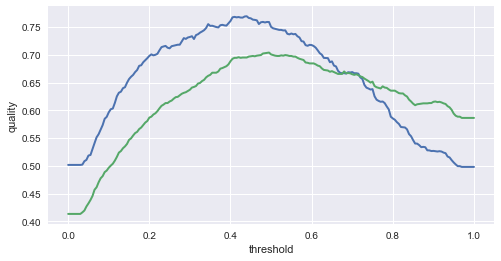

In [96]:
xgb_a, xgb_pr = combine_results(xgb_res, cv,  df_p.shape[0])
review(df_p, xgb_a, xgb_pr, "ibs")

In [114]:
new_df.to_csv("hrv_results.csv")